# Requirement on antenna pattern
## SCI-MIS-0250: Knowledge of the antenna pattern in amplitude
The susceptibility of the observatory to the strain of a GW shall be known to better than 10−4 in amplitude for any polarisation of the GW, at any given time during the mission lifetime, and for any given position of the GW source in the sky.
## SCI-MIS-0260: Knowledge of the antenna pattern in phase
The susceptibility of the observatory to the strain of a GW shall be known to better than 10−2 rad in phase for any polarisation of the GW, at any given time during the mission lifetime, and for any given position of the GW source in the sky.
## Rationale: 
Many science objectives and science investigations depend on the knowledge of the strain of the gravitational wave signal that needs to be calculated from the measured signal with sufficient accuracy. Requiring the which is given by this requirement. In the flow-down, this sets requirements on spacecraft (S/C) position knowledge, knowledge of the laser wavelength, precision of the reconstruction etc.

3D orbit plot saved to 3d_orbit_around_sun.png


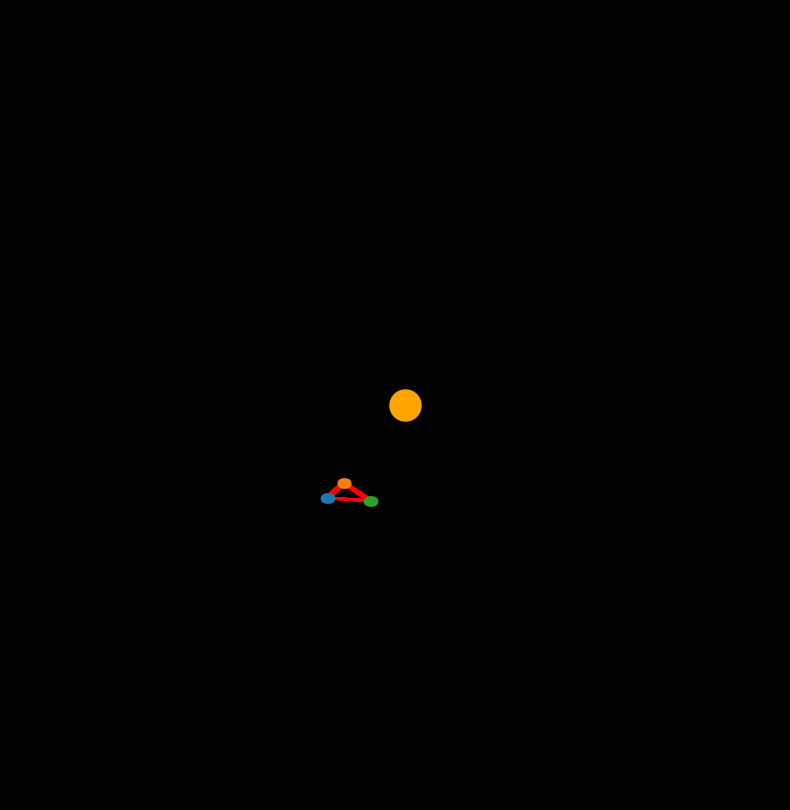

In [1]:
# run with python as
# nohup python assess_impact.py > out.out &
import os, sys

# Get CUDA device and frequency of GB binary from command-line arguments
cuda_device = 3
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import sawtooth
from scipy.signal.windows import tukey
import h5py
from fastlisaresponse import pyResponseTDI, ResponseWrapper
from astropy import units as un
from lisatools.utils.constants import *
# make nice plots
np.random.seed(2601)

from utils import *

fpath = "new_orbits.h5"
T = 1.0/365  # years
plot_orbit_3d(fpath, T)
plt.show()

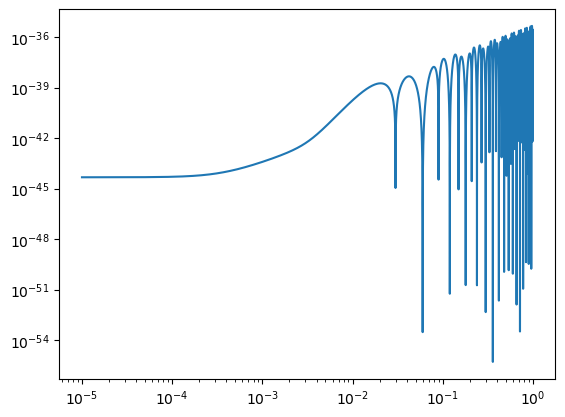

In [2]:
psd = np.load("../EMRI-FoM/pipeline/TDI2_AE_psd.npy")
# interpolate the psd with a cubic spline
from scipy.interpolate import CubicSpline
psd_interp = CubicSpline(psd[:, 0], psd[:, 1])
plt.loglog(psd[:, 0], psd[:, 1], label="Original PSD")


In [3]:
use_gpu = True
dt = 0.25
gb = GBWave(use_gpu=use_gpu, T=T, dt=dt)

def get_response(orbit):
    # default settings
    # order of the langrangian interpolation
    order = 25
    # 1st or 2nd or custom (see docs for custom)
    tdi_gen = "2nd generation"
    index_lambda = 6
    index_beta = 7
    t0 = 10000.0  # time at which signal starts (chops off data at start of waveform where information is not correct)
    tdi_kwargs_esa = dict(order=order, tdi=tdi_gen, tdi_chan="AET",)
    return ResponseWrapper(
    gb,
    T,
    dt,
    index_lambda,
    index_beta,
    t0=t0,
    flip_hx=False,  # set to True if waveform is h+ - ihx
    use_gpu=use_gpu,
    remove_sky_coords=True,  # True if the waveform generator does not take sky coordinates
    is_ecliptic_latitude=True,  # False if using polar angle (theta)
    remove_garbage=True,  # removes the beginning of the signal that has bad information
    orbits=orbit,
    **tdi_kwargs_esa,
    )

def get_variation(time_vec, t_initial=0, period=14*86400, rho=1.0):
    """
    Generate a periodic variation in the local orbital frame
    :param time_vec: time vector
    :param t_initial: initial time
    :param period: period of the variation
    :param rho: amplitude of the variation
    :return: 2D array of shape (len(time_vec), 3)
    """
    size = len(time_vec)
    periodic = sawtooth(2 * np.pi * (time_vec-t_initial)/period)
    # res =  random_vectors_on_sphere(size=size)[0] * rho * (1 + periodic[:,None])/2
    periodic = (1-np.cos(2 * np.pi * (time_vec-t_initial)/period)) / 2
    res =  random_vectors_on_sphere(size=size)[0] * rho * periodic[:,None]
    # fixed random
    res = np.ones_like(random_vectors_on_sphere(size=size)) * random_vectors_on_sphere(size=size)[0] * rho
    # random
    res = random_vectors_on_sphere(size=size) * rho
    return res
    
    
def compute_inn_and_den(fft_def, fft_dev, psd_, mask_sum, df):
    """
    Compute the inn and den quantities for FFT-based analysis.

    :param fft_def: FFT of the default signal
    :param fft_dev: FFT of the deviated signal
    :param psd_: Power Spectral Density (PSD) values
    :param mask_sum: Mask for the frequency range of interest
    :param df: Frequency resolution
    :return: Tuple containing inn and den values
    """
    d_h = 4 * xp.sum(fft_def[mask_sum].conj() * fft_dev[mask_sum] / psd_).real * df
    d_d = 4 * xp.sum(fft_dev[mask_sum].conj() * fft_dev[mask_sum] / psd_).real * df
    h_h = 4 * xp.sum(fft_def[mask_sum].conj() * fft_def[mask_sum] / psd_).real * df
    A_est = d_h / h_h
    tan_phi_est = 4 * xp.sum(fft_def[mask_sum].conj() * fft_dev[mask_sum] / psd_).imag * df / d_h
    Im = xp.sum(fft_def[mask_sum].conj() * fft_dev[mask_sum] / psd_).imag * df
    Re = d_h 
    tan_phi_est = Im / Re
    phi_est = np.arctan(tan_phi_est)
    # print("estimated A and phi and cos phi", A_est, phi_est, np.cos(phi_est))
    loglike_diff = 4 * xp.sum(xp.abs(fft_def[mask_sum] - fft_dev[mask_sum])**2 / psd_).real * df
    # print(loglike_diff, d_d + h_h -2*d_h)
    mismatch = xp.abs(1 - d_h / xp.sqrt(h_h * d_d))
    snr = xp.sqrt(h_h)
    print("mismatch", mismatch, "snr", snr, "loglike_diff")
    return A_est, phi_est, mismatch, snr

def compute_information_matrix(A, delta_phi, rho_squared=1.0):
    """
    Compute the Fisher Information Matrix based on the second derivatives of the log-likelihood.

    Parameters:
        A (float): Amplitude scaling factor.
        delta_phi (float): Phase difference in radians.
        rho_squared (float): The squared signal-to-noise ratio (SNR), ρ².

    Returns:
        np.ndarray: 2x2 Fisher Information Matrix.
    """
    # Compute the second derivatives
    d2L_dA2 = rho_squared  # -∂²_A ℒ
    d2L_dphi2 = rho_squared * A * np.cos(delta_phi)  # -∂²_δφ ℒ
    d2L_dAdphi = -rho_squared * np.sin(delta_phi)  # -∂_A ∂_δφ ℒ

    # Construct the Fisher Information Matrix
    fisher_matrix = np.array([
        [d2L_dA2, d2L_dAdphi],
        [d2L_dAdphi, d2L_dphi2]
    ])

    return fisher_matrix

A = 1.0  # Example amplitude scaling factor
delta_phi = 0.0  # Example phase difference in radians

fisher_matrix = compute_information_matrix(A, delta_phi)
print("Fisher Information Matrix:")
print(fisher_matrix)

Fisher Information Matrix:
[[ 1. -0.]
 [-0.  1.]]


The loglikelihood $\mathcal{L}$ for the analysis of data in the absence of noise is
$$
-2\mathcal{L} = < R_{\rm true}(h_{+,\times}, \vec \Omega) - R_{\rm app}(h_{+,\times}, \vec \Omega) | R_{\rm true}(h_{+,\times}, \vec \Omega) - R_{\rm app}(h_{+,\times}, \vec \Omega)>
$$
If we assume that the deviation in the response due to the constellation can be approximated as:
$$
R_{\rm app}(h_{+,\times}, \vec \Omega) = R_{\rm true}(h_{+,\times}, \vec \Omega) A e^{i \delta \phi}
$$
Then the likelihood is
$$
-2\mathcal{L} = 
< R_{\rm true}(h_{+,\times}, \vec \Omega) | R_{\rm true}(h_{+,\times}, \vec \Omega)> (1 -2 A \cos {\delta \phi }+ A^2)
$$
and we define $\rho^2 = \rho^2$.

The likelihood derivatives become
$$
-2\partial_A\mathcal{L} = 
-2 \rho^2 (\cos {\delta \phi } - A)
$$
$$
-2\partial_{\delta \phi}\mathcal{L} = 
-2 \rho^2 A (-\sin \delta \phi)
$$
The second derivative are
$$
% -2\partial^2_A\mathcal{L} = -2 \rho^2 (- 1) \qquad 
-\partial^2_A\mathcal{L} = 
\rho^2
$$
$$
-\partial^2_{\delta \phi}\mathcal{L} = 
\rho^2 A \cos \delta \phi
$$
$$
-\partial_A \partial_{\delta \phi}\mathcal{L} = 
- \rho^2 \sin \delta \phi
$$

In [4]:
from lisaorbits import StaticConstellation

def perturbed_static_orbits(arm_lengths, armlength_error, rotation_error, translation_error, rot_fac = 2.127):
    """ Apply perturbations to the static orbits 
    
    We want to create a situation where the armlengths are known very well, but the
    absolute positions of the spacecraft are not known very well.

    This is achieved by applying a small perturbation to the armlengths
    followed by a rotation and translation to the spacecraft 
    positions (around random axis and directions).
    
    Parameters
    ----------
    arm_lengths : np.array
        Nominal armlengths of the constellation.
    armlength_error : float
        Standard deviation of the perturbation to apply to the armlengths, in meters.
    rotation_error : float
        Standard deviation of the rotation to apply to the spacecraft positions, in equivalent meters of displacement.
    translation_error : float
        Standard deviation of the translation to apply to the spacecraft positions, in meters.

    """
    # Create new orbits with perturbed armlengths
    arm_dev = np.random.normal(0, armlength_error, size=(3,))
    print("arm_dev", arm_dev)
    perturbed_ltt_orbits = StaticConstellation.from_armlengths(arm_lengths[0] + arm_dev[0], 
                                                       arm_lengths[1] + arm_dev[1], 
                                                       arm_lengths[2] + arm_dev[2])
    
    # Apply rotation by an angle phi along a random axis in 3d space

    # Generate a random rotation matrix
    # Random axis of rotation
    axis = np.random.randn(3)
    axis /= np.linalg.norm(axis)  # Normalize the axis

    # Average distance of the spacecraft from the center of mass
    avg_distance = np.mean(np.linalg.norm(perturbed_ltt_orbits.sc_positions, axis=1))

    # In the small angle approximation, the rotation by an angle phi causes a displacement
    # of the spacecraft positions by a distance d = r * phi. Solving for phi and using d = error_magnitude gives
    # phi = d / r
    # TODO: improve on the math here; not all rotations affect all S/C, so this is
    # off by a factor of 2 or so; for now just fitted by hand
    angle = rot_fac * rotation_error / avg_distance

    # Rotation matrix using Rodrigues' rotation formula
    K = np.array([[0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]])
    R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.outer(axis, axis)

    # Apply the rotation to the spacecraft positions
    rotated_positions = np.dot(R, perturbed_ltt_orbits.sc_positions.T).T

    # Apply translation to the spacecraft positions
    translation = np.random.normal(0, translation_error, size=(3,))
    perturbed_positions = rotated_positions + translation
    print("translation", translation)
    print("rotation", angle)
    # Create a new StaticConstellation object with the perturbed positions
    perturbed_orbits = StaticConstellation(perturbed_positions[0], perturbed_positions[1], perturbed_positions[2])
    return perturbed_orbits

def get_orbit(arm_lengths=[2.5e9, 2.5e9, 2.5e9], armlength_error=1, rotation_error=50e3, translation_error=50e3):
    porbit = perturbed_static_orbits(
        arm_lengths=arm_lengths, 
        armlength_error=armlength_error, 
        rotation_error=rotation_error, 
        translation_error=translation_error
    )
    porbit.write("temp_orbit.h5", dt=dt, size=int(T*YRSID_SI/dt), t0=0.0, mode="w")    
    return ESAOrbits("temp_orbit.h5",use_gpu=use_gpu)

def create_orb_dev(delta_x, fpath, use_gpu):
    """
    Create an orb_dev object with deviations based on the given sigma.

    Parameters:
    delta_x (float): Size of the deviation.
    fpath (str): File path for the orbit data.
    use_gpu (bool): Whether to use GPU for computations.

    Returns:
    ESAOrbits: The orb_dev object with configured deviations.
    """
    # create the deviation dictionary
    orb_dev = ESAOrbits(fpath, use_gpu=use_gpu)
    deviation = {which: np.zeros_like(getattr(orb_dev, which + "_base")) for which in ["ltt", "x", "n", "v"]}
    
    # time
    time_vec = orb_dev.t_base
    xbase = orb_dev.x_base
    local_orbital_frame_pos = np.sum(xbase, axis=1) / 3
    
    # loop over spacecraft
    for sc in range(3):
        # deviation in the local orbital frame
        deviation_lof = get_variation(time_vec, t_initial=0, period=14 * 86400, rho=delta_x)
        deviation["x"][:, sc, :] += deviation_lof
        deviation["v"][:, sc, :] += np.gradient(deviation_lof, time_vec, axis=0)
    
    orb_dev.configure(linear_interp_setup=True, deviation=deviation)
    return orb_dev


In [5]:
# Create orbit objects
# fpath = "new_orbits.h5"
orb_default = get_orbit(arm_lengths=[2.5e9, 2.5e9, 2.5e9], armlength_error=0.0, rotation_error=0.0, translation_error=0.0) #ESAOrbits(fpath,use_gpu=use_gpu)
deviation = {which: np.zeros_like(getattr(orb_default, which + "_base")) for which in ["ltt", "x", "n", "v"]}
orb_default.configure(linear_interp_setup=True, deviation=deviation)
# default orbit
gb_lisa_esa = get_response(orb_default)

# define variations
# fig 72 of ESA-LISA-ESOC-MAS-RP-0001 Iss2Rev0 - LISA Consolidated Report on Mission Analysis.pdf
# division by 3 because of the three sigma and multiply by 1e3 to convert to meters
# radial
sig_ref = 1e3
sigma_radial = sig_ref * 1e3 /3 #50e3
# along-track
sigma_along = sig_ref * 1e3 /3#10e3
# cross-track
sigma_cross =  sig_ref * 1e3 /3#100e3
list_sigma = [sigma_radial, sigma_along, sigma_cross]

change = "x"
sigma_vec = np.arange(0, 10)
orbit_list = []

for delta_x in sigma_vec:

    # Replace the placeholder with the function call
    # orb_dev = create_orb_dev(delta_x * list_sigma[0], fpath, use_gpu)
    orb_dev = get_orbit(arm_lengths=[2.5e9, 2.5e9, 2.5e9], armlength_error=1, rotation_error=50e3, translation_error=50e3)

    orb_dev.configure(linear_interp_setup=True, deviation=deviation)
    orbit_list.append(orb_dev)


arm_dev [0. 0. 0.]
translation [0. 0. 0.]
rotation 0.0


/data/lsperi/miniconda3/envs/lisa_resp_env/lib/python3.12/site-packages/fastlisaresponse/response.py:714: UserWarning: Tobs is larger than available orbital information time array. Reducing Tobs to 86460.25
  warnings.warn(


arm_dev [ 0.49659581 -0.59700203 -0.07581878]
translation [ -45664.0852981  -118070.46611322  -30239.06379819]
rotation 7.36814413557113e-05
arm_dev [-0.97899525 -0.25849316 -0.83545859]
translation [ 69918.64798491  77592.20934485 -59869.45327533]
rotation 7.368144137434506e-05
arm_dev [ 0.81225738 -1.14778978  0.28663415]
translation [-57384.57069721  42062.0487147  -37008.86832153]
rotation 7.368144135446043e-05
arm_dev [ 0.29321763 -1.01683177  0.14765761]
translation [ 16186.45276165 -56355.29026233  10575.41396398]
rotation 7.368144135963835e-05
arm_dev [-0.09638954 -0.38373427  0.76911056]
translation [ -7946.41604868 -65070.72014532 -18568.39530701]
rotation 7.368144135114095e-05
arm_dev [-0.53913349 -0.04647752 -0.45644665]
translation [ 44495.6340111  125606.51164982 -56086.54063086]
rotation 7.36814413642174e-05
arm_dev [-0.75681387 -0.55368027  0.66119303]
translation [-40325.15784971 -82582.83039214 -35478.27176878]
rotation 7.368144136035888e-05
arm_dev [ 0.42846961 -0.77

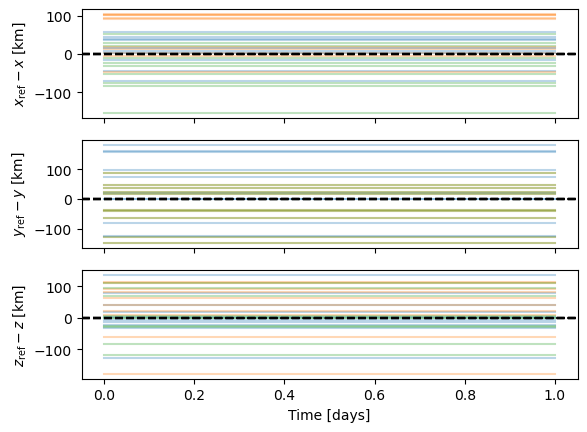

In [6]:
coord_color = [(r"$x_{\rm ref} - x$ [km]", "C0"), (r"$y_{\rm ref} - y$ [km]","C1"), (r"$z_{\rm ref}- z$ [km]","C2")]
fig, ax = plt.subplots(3, 1, sharex=True)
for orb_dev in orbit_list:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    for ii in range(3):
        for sc in range(3):
            ax[ii].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, 
                        (arr_def[:, sc, ii]-arr[:, sc, ii])/1e3, 
                        label=f"SC{sc}",color=coord_color[sc][1], alpha=0.3)
        ax[ii].axhline(0.0, linestyle='--', color='k')
        # ax[ii].axhline(list_sigma[ii]/1e3, linestyle='--', color='k')
        # ax[ii].axhline(-list_sigma[ii]/1e3, linestyle='--', color='k')
        ax[ii].set_ylabel(coord_color[ii][0])
        # ax[ii].set_xlim(0, 30)
        

    ax[2].set_xlabel("Time [days]")
plt.savefig("orbits_deviation.png")

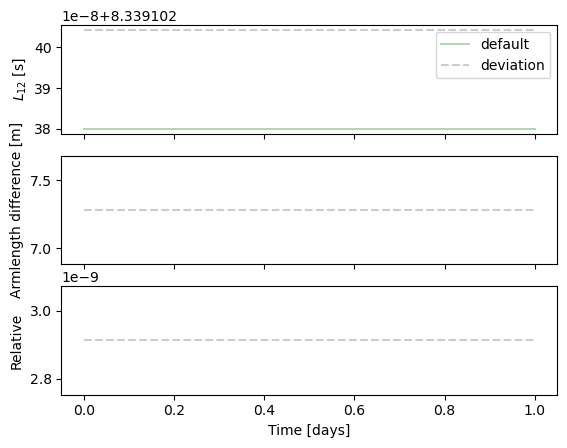

In [7]:
sc = 0
coord_color = [("$L_{12}$ [s]", "g")]
fig, ax = plt.subplots(3, 1, sharex=True)
for orb_dev in orbit_list[:1]:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    ii = 0
    deviation = np.linalg.norm(arr_def[:, ii]-arr_def[:, ii+1],axis=1)/C_SI
    ax[ii].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, 
                deviation, 
                color=coord_color[sc][1], alpha=0.3, label="default")
    
    ref = np.linalg.norm(arr[:, ii]-arr[:, ii+1],axis=1)/C_SI
    ax[ii].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, ref, linestyle='--', color='k',alpha=0.2, label="deviation")
    ax[ii].set_ylabel(coord_color[ii][0])
    # ax[ii].set_ylim([ref[0].min(), ref[1000].max()])
        
for orb_dev in orbit_list[:1]:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    ii = 0
    deviation = np.linalg.norm(arr_def[:, ii]-arr_def[:, ii+1],axis=1) # /C_SI
    ref = np.linalg.norm(arr[:, ii]-arr[:, ii+1],axis=1) # /C_SI
    diff = np.abs(ref-deviation)
    ax[1].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, diff, linestyle='--', color='k',alpha=0.2)
    ax[1].set_ylabel("Armlength difference [m]")


for orb_dev in orbit_list[:1]:
    arr = getattr(orb_dev, change)
    arr_def = getattr(orb_default, change)
    ii = 0
    deviation = np.linalg.norm(arr_def[:, ii]-arr_def[:, ii+1],axis=1)/C_SI
    ref = np.linalg.norm(arr[:, ii]-arr[:, ii+1],axis=1)/C_SI
    diff = np.abs(ref-deviation)/ref
    ax[2].plot(np.arange(arr.shape[0]) * orb_default.dt / 86400, diff, linestyle='--', color='k',alpha=0.2)
    ax[2].set_ylabel("Relative")

ax[2].set_xlabel("Time [days]")
# plt.xlim([0.0, 7])
ax[0].legend()
plt.savefig("armlength_deviation.png")


Text(0, 0.5, 'Deviation Radius [km]')

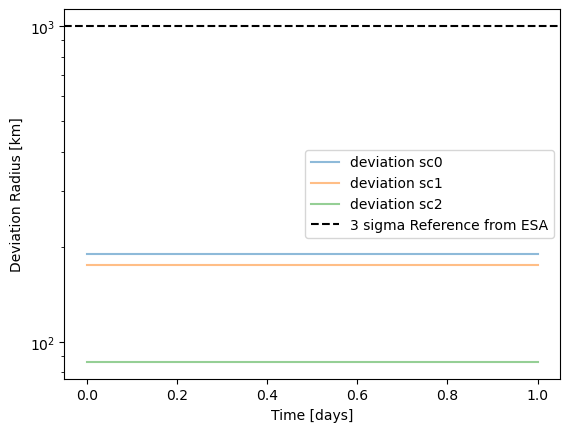

In [8]:
plt.figure()
sc = 0
for sc in range(3):
    for delta_x, orb_dev in zip(sigma_vec[:1], orbit_list[:1]):
        # plot the deviation
        time_vec = orb_dev.t
        # deviation_lof = orb_dev.deviation["x"][:, sc, :]
        deviation_lof = orb_dev.x[:, sc, :] - orb_default.x[:, sc, :]
        # plot deviation
        # print(deviation_lof)
        # print(delta_x, np.diff(np.linalg.norm(deviation_lof,axis=1))/1e3 )

        plt.semilogy(time_vec/86400, np.linalg.norm(deviation_lof,axis=1)/1e3 ,label=f"deviation sc{sc}", alpha=0.5)

plt.axhline(1e3, linestyle='--', color='k', label="3 sigma Reference from ESA")
# plt.xlim([0.0, 7])
# plt.ylim([0.5, 4e4])
plt.xlabel("Time [days]")
plt.legend()
plt.ylabel("Deviation Radius [km]")

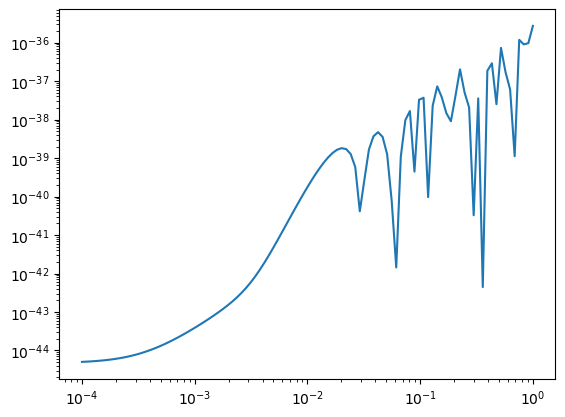

In [9]:
plt.figure()
ff = np.logspace(-4, 0.0, 100)
plt.loglog(ff,psd_interp(ff))

In [40]:
# define GB default parameters
A = 1e-22
gb_frequency = np.logspace(-4, -1, 5)
fdot = 0.0
# sky
# import healpy as hp
# nside = 2
# npix = hp.nside2npix(nside)
# thetas, phis = hp.pix2ang(nside, np.arange(npix))
# Conversion from colatitude to latitude
# betas, lambs = np.pi / 2 - thetas, phis
# A, f, fdot, iota, phi0, psi, lam, beta
# betas.shape

# def draw_parameters(A=1e-22, f=1e-3, fdot=1e-17):
#     if A is None:
#         A = np.random.uniform(1e-24, 1e-22)
#     if f is None:
#         f = np.random.uniform(1e-4, 1e-2)
#     if fdot is None:
#         fdot = np.random.uniform(-1e-17, 1e-17)
#     # draw random parameters
#     cos_inc = np.random.uniform(-1, 1)  # Random cosines of polar angles
#     iota = np.arccos(cos_inc) #np.random.uniform(0, np.pi)
#     phi0 = np.random.uniform(0, 2 * np.pi)
#     psi = np.random.uniform(0, 2 * np.pi)
#     cos_lam = np.random.uniform(-1, 1)  # Random cosines of polar angles
#     lam = np.arccos(cos_lam)-np.pi/2 # np.random.uniform(-np.pi / 2, np.pi / 2)
#     beta = np.random.uniform(0.0, 2 * np.pi)
#     return A, f, fdot, iota, phi0, psi, lam, beta


----------------------------
Frequency 0.0001 [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
Realization 0 [1.00000000e-22 1.00000000e-04 0.00000000e+00 2.13145669e-01
 5.94029717e+00 2.45171078e+00 1.29316878e+00 5.45270891e+00]


/data/lsperi/miniconda3/envs/lisa_resp_env/lib/python3.12/site-packages/fastlisaresponse/response.py:411: UserWarning: Input waveform is longer than available orbital information. Trimming to fit orbital information.
  warnings.warn(


number of bins 50.0
mismatch 4.2387551246747535e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 7.601602569629051e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 2.3094153256408845e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 1.5331431679754814e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 1.2901654633523663e-08 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 9.194281336277754e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 5.030283967144555e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 1.077072875332874e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 8.318966182585541e-09 snr 0.0010987539778389397 loglike_diff
number of bins 50.0
mismatch 5.182653195490161e-09 snr 0.0010987539778389397 loglike_diff
Realization 1 [ 1.00000000e-22  1.00000000e-04  0.00000000e+00  1.08549711e+00
  1.01615246e+00 

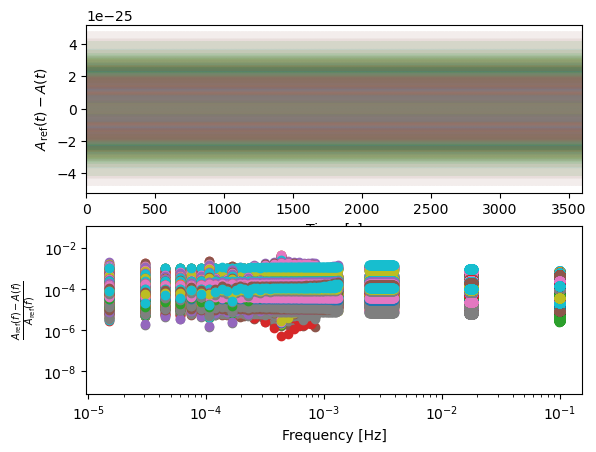

In [41]:
# decie how many variations
channel_generator = [get_response(orb_dev) for orb_dev in orbit_list]

# randomly draw the sky coordinates
Ndraws = 100
par_list = np.asarray([draw_parameters(A=A, f=1e-3, fdot=fdot) for i in range(Ndraws)])
# dict of results per each frequency
result_dict = {f: [] for f in gb_frequency}
# result_dict["gb_frequency"] = gb_frequency

fig, ax = plt.subplots(2, 1, sharex=False)

for f in gb_frequency:
    print("----------------------------")
    par_list[:,1] = f
    print("Frequency", f, par_list[:,1])

    for realization in range(Ndraws):
        print("Realization", realization, par_list[realization])
        
        # print(realization, par_list[realization])
        # print("Generating channels")
        chans = [channel_generator[i](*par_list[realization]) for i in range(len(channel_generator))]
        chans_default = gb_lisa_esa(*par_list[realization])
        # print("Channels generated")

        # Save deviations for each delta_x
        for chan in chans:

            for i, lab in enumerate(["A"]):

                tukey_window = xp.asarray(tukey(len(chan[i]), alpha=0.5))
                fft_f = xp.fft.rfftfreq(len(chan[i]), dt)
                df = fft_f[1] - fft_f[0]
                delta_w = 50 * df # f * 1e-4 + fdot * T * YRSID_SI + 1/YRSID_SI * 4 # https://arxiv.org/pdf/2307.03763
                print("number of bins", delta_w/df)
                mask_sum = (fft_f > f-delta_w) & (fft_f < f+delta_w)
                # mask_sum = (fft_f > 5e-5) & (fft_f < 1.0)
                fft_def = xp.fft.rfft(chans_default[i]*tukey_window,axis=1)*dt
                fft_dev = xp.fft.rfft(chan[i]*tukey_window,axis=1)*dt
                
                # plt.plot(chan[i].get())
                psd_ = xp.asarray(psd_interp(fft_f[mask_sum].get()))
                df = fft_f[1] - fft_f[0]

                A_est, phi_est, mismatch, snr = compute_inn_and_den(fft_def, fft_dev, psd_, mask_sum, df)
                
                out = [np.abs(1-A_est.get()), np.abs(phi_est.get()), np.abs(mismatch.get()), np.float64(snr.get())]
                result_dict[f] += [ out ]
                
                abs_ = np.abs((fft_def[mask_sum] - fft_dev[mask_sum]).get())/np.abs(fft_def[mask_sum].get())
                # ang_ = (np.angle(fft_def[mask_sum].get()) - np.angle(fft_dev[mask_sum].get()))
                # plt.loglog(fft_f[mask_sum].get(), abs_, '.')
                t_vec = np.arange(len(chan[i])) * dt
                ax[0].plot(t_vec, (chan[i] - chans_default[i]).get(), alpha=0.1)
                ax[1].loglog(fft_f[mask_sum].get(), abs_, 'o')


ax[0].set_ylabel(r"$A_{\rm ref}(t) - A(t)$")
ax[0].set_xlabel("Time [s]")
ax[0].set_xlim([0.0, 3600])
ax[1].set_ylabel(r"$\frac{A_{\rm ref}(f) - A(f)}{A_{\rm ref}(f)}$")
ax[1].set_xlabel("Frequency [Hz]")
# ax[1].loglog(psd[:,0], psd[:,1]**0.5, label="ASD", alpha=0.1)
plt.show()


In [42]:
import json
with open(f"temp_all_freq_results_T{T}.json", "w") as json_file:
    json.dump(result_dict, json_file)

with open(f"temp_all_freq_results_T{T}.json", "r") as json_file:
    result_dict = json.load(json_file)

# result_dict.keys()


In [43]:
# A = 100.0  # Example amplitude scaling factor
# delta_phi = 0.0  # Example phase difference in radians

# fisher_matrix = compute_information_matrix(A, delta_phi)
# print("Fisher Information Matrix:")
# print(fisher_matrix)

In [44]:
np.asarray(result_dict[str(f)]).shape

(1000, 4)

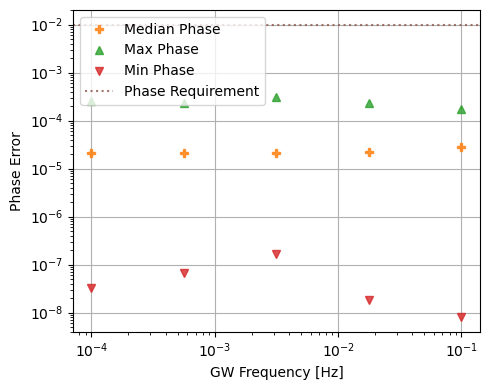

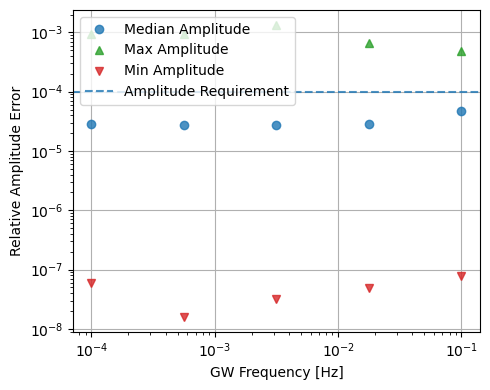

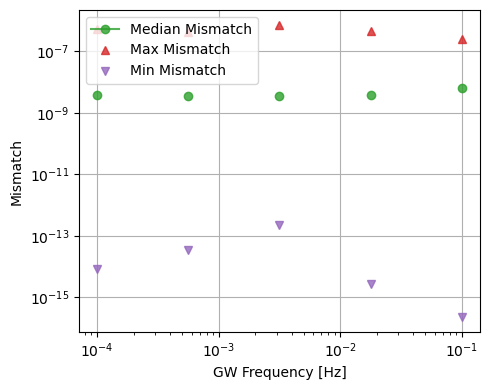

In [45]:
# Plot for Phase
plt.figure(figsize=(5, 4))
for f in gb_frequency:
    res_list = np.asarray(result_dict[str(f)])
    res_median = np.median(res_list, axis=0)
    res_max = np.max(res_list, axis=0)
    res_min = np.min(res_list, axis=0)
    plt.plot(f, res_median[1], "P", alpha=0.8, color="C1", label="Median Phase" if f == gb_frequency[0] else None)
    plt.plot(f, res_max[1], "^", alpha=0.8, color="C2", label="Max Phase" if f == gb_frequency[0] else None)
    plt.plot(f, res_min[1], "v", alpha=0.8, color="C3", label="Min Phase" if f == gb_frequency[0] else None)
plt.axhline(y=1e-2, linestyle=":", color="C5", alpha=0.8, label="Phase Requirement")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("GW Frequency [Hz]")
plt.ylabel(r"Phase Error")
plt.legend(loc="upper left")
plt.tight_layout()
plt.grid()
plt.savefig("phase_error_plot.png", dpi=300)

# Plot for Relative Amplitude
plt.figure(figsize=(5, 4))
for f in gb_frequency:
    res_list = np.asarray(result_dict[str(f)])
    res_median = np.median(res_list, axis=0)
    res_max = np.max(res_list, axis=0)
    res_min = np.min(res_list, axis=0)
    plt.plot(f, res_median[0], "o", alpha=0.8, color="C0", label="Median Amplitude" if f == gb_frequency[0] else None)
    plt.plot(f, res_max[0], "^", alpha=0.8, color="C2", label="Max Amplitude" if f == gb_frequency[0] else None)
    plt.plot(f, res_min[0], "v", alpha=0.8, color="C3", label="Min Amplitude" if f == gb_frequency[0] else None)
plt.axhline(y=1e-4, linestyle="--", color="C0", alpha=0.8, label="Amplitude Requirement")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("GW Frequency [Hz]")
plt.ylabel(r"Relative Amplitude Error")
plt.legend(loc="upper left")
plt.tight_layout()
plt.grid()
plt.savefig("relative_amplitude_error_plot.png", dpi=300)

# Plot for Mismatch
plt.figure(figsize=(5, 4))
for f in gb_frequency:
    res_list = np.asarray(result_dict[str(f)])
    res_median = np.median(res_list, axis=0)
    res_max = np.max(res_list, axis=0)
    res_min = np.min(res_list, axis=0)
    plt.plot(f, res_median[2], "-o", alpha=0.8, color="C2", label="Median Mismatch" if f == gb_frequency[0] else None)
    plt.plot(f, res_max[2], "^", alpha=0.8, color="C3", label="Max Mismatch" if f == gb_frequency[0] else None)
    plt.plot(f, res_min[2], "v", alpha=0.8, color="C4", label="Min Mismatch" if f == gb_frequency[0] else None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("GW Frequency [Hz]")
plt.ylabel("Mismatch")
plt.legend(loc="upper left")
plt.tight_layout()
plt.grid()
plt.savefig("mismatch_plot.png", dpi=300)


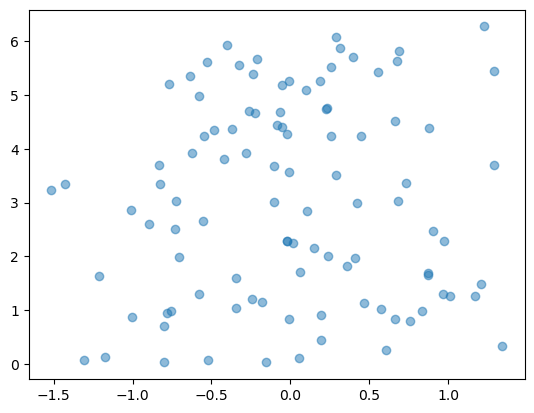

In [46]:
A, f, fdot, iota, phi0, psi, lam, beta = np.asarray(par_list).T
phase_errors = np.array([result[1] for result in res_list])  # Assuming res_list contains phase errors

plt.plot(lam, beta, "o", alpha=0.5)
# betas.shape

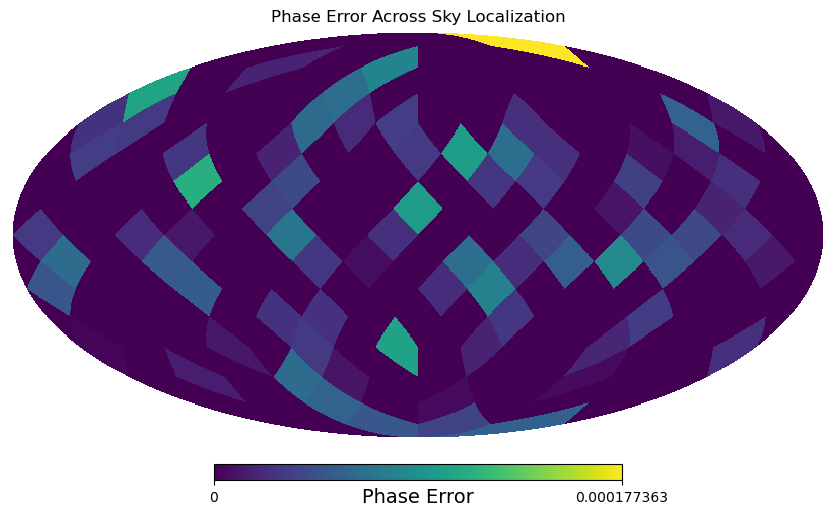

In [47]:
import healpy as hp
nside = 4
npix = hp.nside2npix(nside)
# Create a map with the same number of pixels as the sky localization
phase_map = np.zeros(npix) # Initialize the map with zeros
thetas = lam + np.pi/2
phis = beta
# Assign phase errors to the corresponding pixels
for i, (theta, phi) in enumerate(zip(thetas, phis)):
    pixel_index = hp.ang2pix(nside, theta, phi)
    phase_map[pixel_index] = phase_errors[i]

# Plot the mollview map
hp.mollview(phase_map, title="Phase Error Across Sky Localization", unit="Phase Error", cmap="viridis")
plt.show()

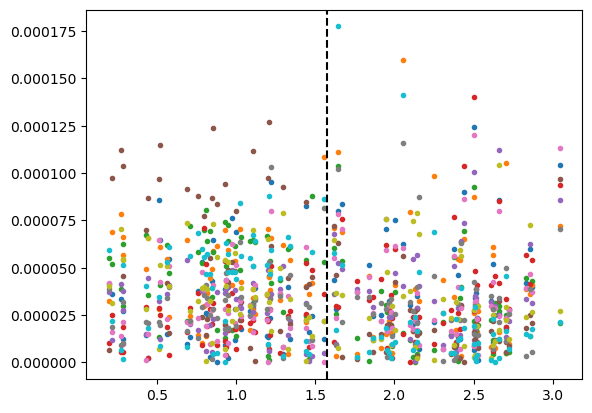

In [55]:
plt.plot(iota, phase_errors.reshape((100,10)),'.')
plt.axvline(np.pi/2, linestyle='--', color='k')